In [1]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydub import AudioSegment
from librosa.feature.rhythm import tempo as compute_tempo
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
import soundfile as sf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [2]:
# Paths
original_root = 'genres'
durations_sec = [1, 2, 3, 5, 6, 10]

# Iterate through each genre subfolder
for genre in os.listdir(original_root):
    genre_path = os.path.join(original_root, genre)
    if not os.path.isdir(genre_path):
        continue

    for duration in durations_sec:
        output_root = f'genres_{duration}sec'
        output_genre_path = os.path.join(output_root, genre)
        os.makedirs(output_genre_path, exist_ok=True)

        # Process each .au file
        for file in os.listdir(genre_path):
            if file.endswith('.au'):
                file_path = os.path.join(genre_path, file)
                audio = AudioSegment.from_file(file_path, format='au')

                # Split into chunks of given duration
                duration_ms = duration * 1000
                num_chunks = len(audio) // duration_ms

                base_name = os.path.splitext(file)[0]
                for i in range(num_chunks):
                    start_ms = i * duration_ms
                    end_ms = start_ms + duration_ms
                    chunk = audio[start_ms:end_ms]

                    output_filename = f"{base_name}_{i}.wav"
                    chunk.export(os.path.join(output_genre_path, output_filename), format="wav")


In [2]:

def extract_features(file_path):
    try:
        audio, sample_rate = librosa.load(file_path, sr=None)
        
        mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13).T, axis=0) #supposedly 13 coeffs is a magic number for speech processing analysis but it can change
        chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sample_rate).T, axis=0) #gives 12 data points, one for each key in an octave
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sample_rate).T, axis=0) #sound brightness
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sample_rate).T, axis=0) #frequency spread
        zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=audio).T, axis=0) #noisiness
        rms_energy = np.mean(librosa.feature.rms(y=audio).T, axis=0) #loudness
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sample_rate).T, axis=0) #frequency where most energy is concentrated

        onset_env = librosa.onset.onset_strength(y=audio, sr=sample_rate) #to get tempo
        tempo_value = compute_tempo(onset_envelope=onset_env, sr=sample_rate)[0]

        features = np.hstack([
            mfccs, chroma, spectral_centroid, spectral_bandwidth, zero_crossing_rate,
            rms_energy, spectral_rolloff, [tempo_value]
        ])
        return features

    except Exception as e:
        print(f'Error {file_path}: {e}')
        return None
    

In [ ]:
# Feature column names
mfcc_columns = [f'mfcc_{i}' for i in range(13)]
chroma_columns = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
other_features = ['spectral_centroid', 'spectral_bandwidth', 'zero_crossing_rate', 'rms_energy', 'spectral_rolloff', 'tempo']
feature_names = mfcc_columns + chroma_columns + other_features

# List of durations to process
durations = [1, 2, 3, 5, 6, 10]

# Loop through each duration
for sec in durations:
    directory_path = f'./genres_{sec}sec/'
    data = []

    print(f"\nProcessing data for: genres_{sec}sec")
    
    for genre_folder in os.listdir(directory_path):
        genre_path = os.path.join(directory_path, genre_folder)
        if os.path.isdir(genre_path):
            print(f"  Genre: {genre_folder}")
            for file_name in os.listdir(genre_path):
                if file_name.endswith('.wav'):
                    file_path = os.path.join(genre_path, file_name)
                    features = extract_features(file_path)
                    if features is not None:
                        data.append([genre_folder, file_name, *features])
    
    # Create and save DataFrame
    df = pd.DataFrame(data, columns=['genre', 'filename'] + feature_names)
    df = df.round(3)
    output_csv = f'audio_features_{sec}sec.csv'
    df.to_csv(output_csv, index=False)
    print(f"Saved {output_csv} with {len(df)} rows")


=== Sampling Duration: 1 sec ===

KNN Accuracy: 0.773

SVM Accuracy: 0.773

Logistic Regression Accuracy: 0.563

=== Sampling Duration: 2 sec ===

KNN Accuracy: 0.808

SVM Accuracy: 0.788

Logistic Regression Accuracy: 0.599

=== Sampling Duration: 3 sec ===

KNN Accuracy: 0.805

SVM Accuracy: 0.773

Logistic Regression Accuracy: 0.598

=== Sampling Duration: 5 sec ===

KNN Accuracy: 0.835

SVM Accuracy: 0.795

Logistic Regression Accuracy: 0.641

=== Sampling Duration: 6 sec ===

KNN Accuracy: 0.804

SVM Accuracy: 0.774

Logistic Regression Accuracy: 0.645

=== Sampling Duration: 10 sec ===

KNN Accuracy: 0.735

SVM Accuracy: 0.765

Logistic Regression Accuracy: 0.633


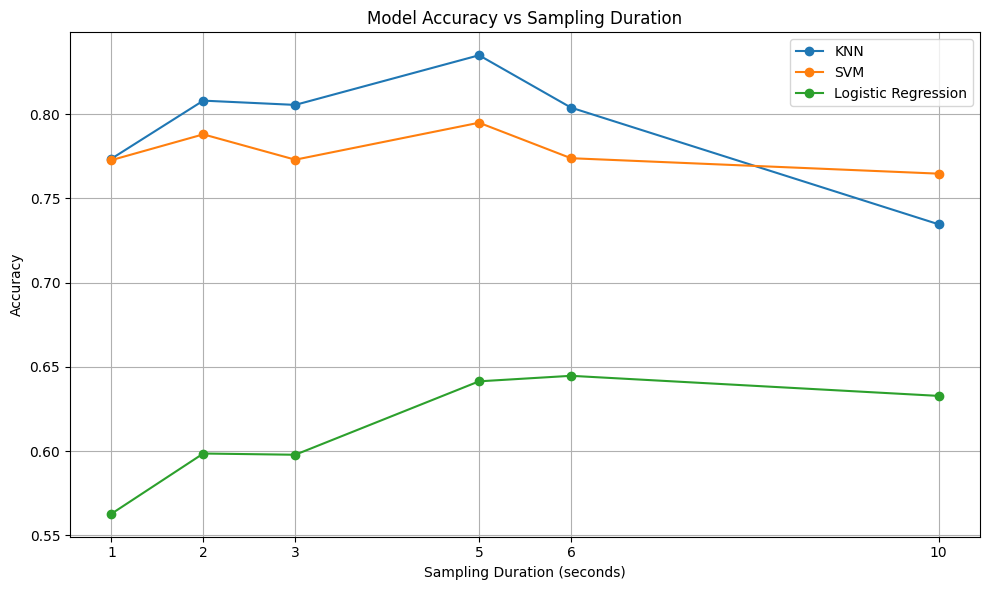

In [4]:
# Sampling durations
durations = [1, 2, 3, 5, 6, 10]

# Models to evaluate
models = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'SVM': SVC(kernel='rbf', C=1, gamma='scale'),
    'Logistic Regression': LogisticRegression(max_iter=1000)
}

# Store accuracies
results = {model_name: [] for model_name in models}

# Loop through each CSV file
for sec in durations:
    file_path = f'audio_features_{sec}sec.csv'
    print(f'\n=== Sampling Duration: {sec} sec ===')

    # Load dataset
    df = pd.read_csv(file_path)

    # Features and labels
    X = df.drop(columns=['genre', 'filename'])
    y = df['genre']

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train and evaluate models
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        acc = accuracy_score(y_test, y_pred)
        results[name].append(acc)
        print(f'\n{name} Accuracy: {acc:.3f}')
        # Uncomment below to see full report
        # print(classification_report(y_test, y_pred))

# Plotting
plt.figure(figsize=(10, 6))
for name, accs in results.items():
    plt.plot(durations, accs, marker='o', label=name)

plt.title('Model Accuracy vs Sampling Duration')
plt.xlabel('Sampling Duration (seconds)')
plt.ylabel('Accuracy')
plt.xticks(durations)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [2]:
# Load dataset
df = pd.read_csv('audio_features_5sec.csv')
# Check for missing values
missing_counts = df.isnull().sum()
print("Missing values per column:\n", missing_counts)

# Check for string "nan" in each column
string_nan_counts = (df.astype(str) == 'nan').sum()
print("Occurrences of string 'nan' per column:\n", string_nan_counts)


Missing values per column:
 genre                 0
filename              0
mfcc_0                0
mfcc_1                0
mfcc_2                0
mfcc_3                0
mfcc_4                0
mfcc_5                0
mfcc_6                0
mfcc_7                0
mfcc_8                0
mfcc_9                0
mfcc_10               0
mfcc_11               0
mfcc_12               0
C                     0
C#                    0
D                     0
D#                    0
E                     0
F                     0
F#                    0
G                     0
G#                    0
A                     0
A#                    0
B                     0
spectral_centroid     0
spectral_bandwidth    0
zero_crossing_rate    0
rms_energy            0
spectral_rolloff      0
tempo                 0
dtype: int64
Occurrences of string 'nan' per column:
 genre                 0
filename              0
mfcc_0                0
mfcc_1                0
mfcc_2                0
mfcc_3

In [3]:
X = df.drop(columns=['genre', 'filename'])
y = df['genre']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ----------------------------
# KNN Hyperparameter Tuning
# ----------------------------
knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # Manhattan (1) and Euclidean (2)
}

knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='accuracy', n_jobs=-1)
knn_grid.fit(X_train_scaled, y_train)

# Best KNN model
best_knn = knn_grid.best_estimator_
knn_pred = best_knn.predict(X_test_scaled)
knn_acc = accuracy_score(y_test, knn_pred)

print("\n=== Best KNN Model ===")
print("Best Parameters:", knn_grid.best_params_)
print(f"Accuracy: {knn_acc:.3f}")
print(classification_report(y_test, knn_pred))

# ----------------------------
# SVM Hyperparameter Tuning
# ----------------------------
svm_params = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

svm_grid = GridSearchCV(SVC(), svm_params, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train_scaled, y_train)

# Best SVM model
best_svm = svm_grid.best_estimator_
svm_pred = best_svm.predict(X_test_scaled)
svm_acc = accuracy_score(y_test, svm_pred)

print("\n=== Best SVM Model ===")
print("Best Parameters:", svm_grid.best_params_)
print(f"Accuracy: {svm_acc:.3f}")
print(classification_report(y_test, svm_pred))


c:\Users\jsmeg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [       nan 0.86247962 0.80216758 0.83263533        nan 0.8441189
 0.77713041 0.81385947        nan 0.82867614 0.75814316 0.80050265
        nan 0.81260926 0.73811033 0.7863136 ]
  warnings.warn(



=== Best KNN Model ===
Best Parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Accuracy: 0.900
              precision    recall  f1-score   support

       blues       0.91      0.93      0.92       120
   classical       0.96      0.95      0.95       120
     country       0.83      0.81      0.82       119
       disco       0.91      0.94      0.93       120
      hiphop       0.92      0.91      0.91       120
        jazz       0.87      0.88      0.87       120
       metal       0.96      0.91      0.93       120
         pop       0.97      0.90      0.94       120
      reggae       0.85      0.96      0.90       120
        rock       0.83      0.82      0.82       120

    accuracy                           0.90      1199
   macro avg       0.90      0.90      0.90      1199
weighted avg       0.90      0.90      0.90      1199


=== Best SVM Model ===
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.882
              precision    recal

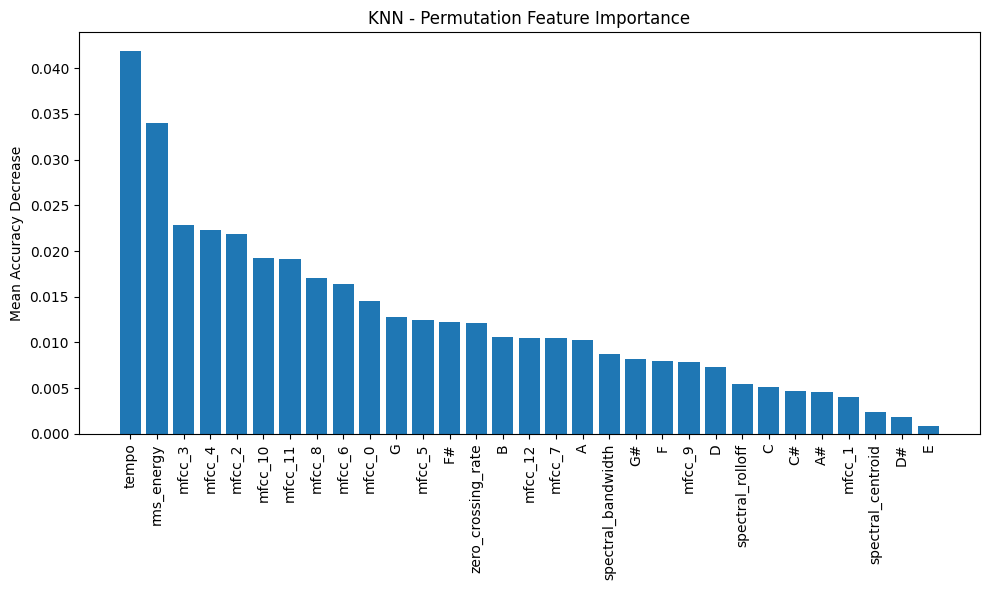

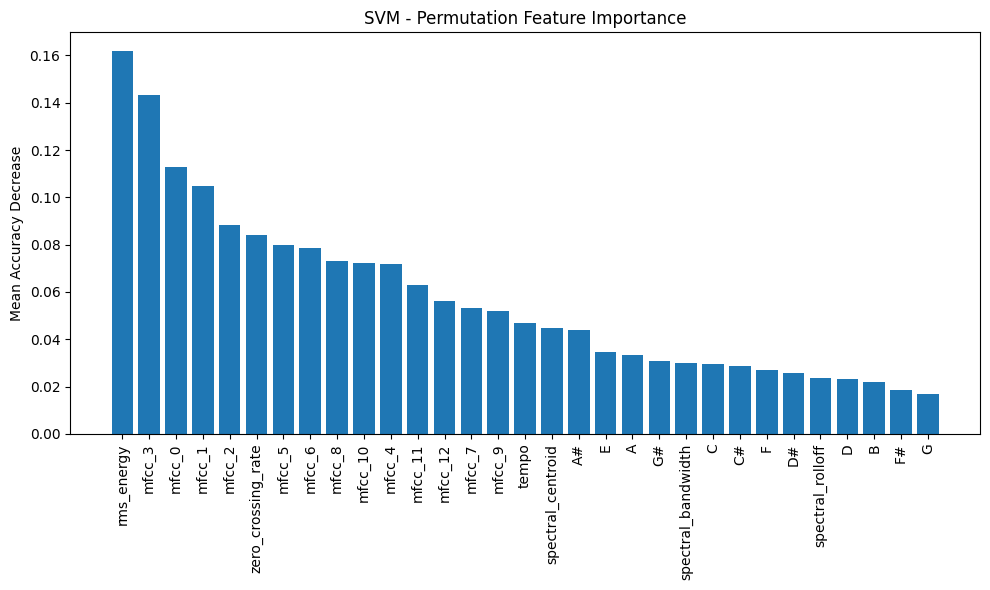

In [4]:
# Get feature names (excluding 'genre' and 'filename')
feature_names = X.columns

def plot_feature_importance(importance_result, model_name):
    importances = importance_result.importances_mean
    sorted_idx = importances.argsort()[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(importances)), importances[sorted_idx], align='center')
    plt.xticks(range(len(importances)), feature_names[sorted_idx], rotation=90)
    plt.title(f'{model_name} - Permutation Feature Importance')
    plt.ylabel('Mean Accuracy Decrease')
    plt.tight_layout()
    plt.show()

# -------------------------
# KNN Feature Importance
# -------------------------
knn_importance = permutation_importance(best_knn, X_test_scaled, y_test, n_repeats=30, random_state=42, n_jobs=-1)
plot_feature_importance(knn_importance, "KNN")

# -------------------------
# SVM Feature Importance
# -------------------------
svm_importance = permutation_importance(best_svm, X_test_scaled, y_test, n_repeats=30, random_state=42, n_jobs=-1)
plot_feature_importance(svm_importance, "SVM")


In [4]:
# Apply PCA after scaling
pca = PCA(n_components=0.95)  # retain 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Original feature count: {X_train.shape[1]}")
print(f"Reduced feature count: {X_train_pca.shape[1]}")

# Fit KNN on PCA-transformed data
knn_grid.fit(X_train_pca, y_train)
best_knn_pca = knn_grid.best_estimator_
knn_pred_pca = best_knn_pca.predict(X_test_pca)
knn_acc_pca = accuracy_score(y_test, knn_pred_pca)

print("\n=== Best KNN Model with PCA ===")
print("Best Parameters:", knn_grid.best_params_)
print(f"Accuracy: {knn_acc_pca:.3f}")
print(classification_report(y_test, knn_pred_pca))

# Fit SVM on PCA-transformed data
svm_grid.fit(X_train_pca, y_train)
best_svm_pca = svm_grid.best_estimator_
svm_pred_pca = best_svm_pca.predict(X_test_pca)
svm_acc_pca = accuracy_score(y_test, svm_pred_pca)

print("\n=== Best SVM Model with PCA===")
print("Best Parameters:", svm_grid.best_params_)
print(f"Accuracy: {svm_acc_pca:.3f}")
print(classification_report(y_test, svm_pred_pca))

Original feature count: 31
Reduced feature count: 20


c:\Users\jsmeg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [       nan 0.82888077 0.78797808 0.81614983        nan 0.8157349
 0.76210606 0.79403541        nan 0.80446773 0.74103222 0.78443751
        nan 0.79027693 0.72350221 0.77108179]
  warnings.warn(



=== Best KNN Model with PCA ===
Best Parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Accuracy: 0.872
              precision    recall  f1-score   support

       blues       0.88      0.88      0.88       120
   classical       0.92      0.88      0.90       120
     country       0.77      0.75      0.76       119
       disco       0.88      0.88      0.88       120
      hiphop       0.90      0.93      0.91       120
        jazz       0.82      0.84      0.83       120
       metal       0.92      0.90      0.91       120
         pop       0.95      0.95      0.95       120
      reggae       0.86      0.94      0.90       120
        rock       0.83      0.77      0.80       120

    accuracy                           0.87      1199
   macro avg       0.87      0.87      0.87      1199
weighted avg       0.87      0.87      0.87      1199


=== Best SVM Model with PCA===
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.852
              p

In [ ]:
def extract_features_ver2(file_path):
    try:
        audio, sample_rate = librosa.load(file_path, sr=None)

        # Base MFCCs
        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
        mfcc_mean = np.mean(mfcc.T, axis=0)

        # Delta MFCCs (1st derivative)
        delta_mfcc = librosa.feature.delta(mfcc)
        delta_mean = np.mean(delta_mfcc.T, axis=0)

        # Delta-Delta MFCCs (2nd derivative)
        delta2_mfcc = librosa.feature.delta(mfcc, order=2)
        delta2_mean = np.mean(delta2_mfcc.T, axis=0)

        # Other features
        chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sample_rate).T, axis=0)
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sample_rate).T, axis=0)
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sample_rate).T, axis=0)
        zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=audio).T, axis=0)
        rms_energy = np.mean(librosa.feature.rms(y=audio).T, axis=0)
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sample_rate).T, axis=0)

        # Tempo
        onset_env = librosa.onset.onset_strength(y=audio, sr=sample_rate)
        tempo_value = compute_tempo(onset_envelope=onset_env, sr=sample_rate)[0]

        features = np.hstack([
            mfcc_mean, delta_mean, delta2_mean,
            chroma, spectral_centroid, spectral_bandwidth,
            zero_crossing_rate, rms_energy, spectral_rolloff,
            [tempo_value]
        ])
        return features

    except Exception as e:
        print(f'Error {file_path}: {e}')
        return None



Processing data for: genres_5sec
  Genre: blues
  Genre: classical
  Genre: country
  Genre: disco
  Genre: hiphop
  Genre: jazz
  Genre: metal
  Genre: pop
  Genre: reggae
  Genre: rock
Saved audio_features_5sec_ver2.csv with 5991 rows


In [ ]:
mfcc_columns = [f'mfcc_{i}' for i in range(13)]
delta_columns = [f'delta_mfcc_{i}' for i in range(13)]
delta2_columns = [f'delta2_mfcc_{i}' for i in range(13)]
chroma_columns = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
other_features = ['spectral_centroid', 'spectral_bandwidth', 'zero_crossing_rate', 'rms_energy', 'spectral_rolloff', 'tempo']

feature_names = mfcc_columns + delta_columns + delta2_columns + chroma_columns + other_features

directory_path = f'./genres_5sec/'
data = []

print(f"\nProcessing data for: genres_5sec")
    
for genre_folder in os.listdir(directory_path):
    genre_path = os.path.join(directory_path, genre_folder)
    if os.path.isdir(genre_path):
        print(f"  Genre: {genre_folder}")
        for file_name in os.listdir(genre_path):
            if file_name.endswith('.wav'):
                file_path = os.path.join(genre_path, file_name)
                features = extract_features_ver2(file_path)
                if features is not None:
                    data.append([genre_folder, file_name, *features])
    
# Create and save DataFrame
df = pd.DataFrame(data, columns=['genre', 'filename'] + feature_names)
df = df.round(3)
output_csv = f'audio_features_5sec_ver2.csv'
df.to_csv(output_csv, index=False)
print(f"Saved {output_csv} with {len(df)} rows")

In [6]:
# Load dataset
df_delta = pd.read_csv('audio_features_5sec_ver2.csv')
# Check for missing values
missing_counts_delta = df_delta.isnull().sum()
print("Missing values per column:\n", missing_counts_delta)

# Check for string "nan" in each column
string_nan_counts_delta = (df_delta.astype(str) == 'nan').sum()
print("Occurrences of string 'nan' per column:\n", string_nan_counts_delta)

Missing values per column:
 genre                 0
filename              0
mfcc_0                0
mfcc_1                0
mfcc_2                0
mfcc_3                0
mfcc_4                0
mfcc_5                0
mfcc_6                0
mfcc_7                0
mfcc_8                0
mfcc_9                0
mfcc_10               0
mfcc_11               0
mfcc_12               0
delta_mfcc_0          0
delta_mfcc_1          0
delta_mfcc_2          0
delta_mfcc_3          0
delta_mfcc_4          0
delta_mfcc_5          0
delta_mfcc_6          0
delta_mfcc_7          0
delta_mfcc_8          0
delta_mfcc_9          0
delta_mfcc_10         0
delta_mfcc_11         0
delta_mfcc_12         0
delta2_mfcc_0         0
delta2_mfcc_1         0
delta2_mfcc_2         0
delta2_mfcc_3         0
delta2_mfcc_4         0
delta2_mfcc_5         0
delta2_mfcc_6         0
delta2_mfcc_7         0
delta2_mfcc_8         0
delta2_mfcc_9         0
delta2_mfcc_10        0
delta2_mfcc_11        0
delta2_mfcc_

In [ ]:
X = df_delta.drop(columns=['genre', 'filename'])
y = df_delta['genre']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ----------------------------
# KNN Hyperparameter Tuning
# ----------------------------
knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # Manhattan (1) and Euclidean (2)
}

knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='accuracy', n_jobs=-1)
knn_grid.fit(X_train_scaled, y_train)

# Best KNN model
best_knn_delta = knn_grid.best_estimator_
knn_delta_pred = best_knn_delta.predict(X_test_scaled)
knn_delta_acc = accuracy_score(y_test, knn_delta_pred)

print("\n=== Best KNN Model ===")
print("Best Parameters:", knn_grid.best_params_)
print(f"Accuracy: {knn_delta_acc:.3f}")
print(classification_report(y_test, knn_delta_pred))

# ----------------------------
# SVM Hyperparameter Tuning
# ----------------------------
svm_params = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

svm_grid = GridSearchCV(SVC(), svm_params, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train_scaled, y_train)

# Best SVM model
best_svm_delta = svm_grid.best_estimator_
svm_delta_pred = best_svm_delta.predict(X_test_scaled)
svm_delta_acc = accuracy_score(y_test, svm_delta_pred)

print("\n=== Best SVM Model ===")
print("Best Parameters:", svm_grid.best_params_)
print(f"Accuracy: {svm_delta_acc:.3f}")
print(classification_report(y_test, svm_delta_pred))

c:\Users\jsmeg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [       nan 0.67967089 0.53839878 0.56552472        nan 0.67278524
 0.55363342 0.57366733        nan 0.66715416 0.54758589 0.56803538
        nan 0.65964242 0.54027987 0.56323371]
  warnings.warn(



=== Best KNN Model ===
Best Parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Accuracy: 0.707
              precision    recall  f1-score   support

       blues       0.73      0.78      0.76       120
   classical       0.83      0.94      0.88       120
     country       0.60      0.43      0.50       119
       disco       0.65      0.62      0.64       120
      hiphop       0.77      0.55      0.64       120
        jazz       0.59      0.82      0.69       120
       metal       0.78      0.89      0.83       120
         pop       0.79      0.72      0.76       120
      reggae       0.80      0.63      0.71       120
        rock       0.58      0.67      0.62       120

    accuracy                           0.71      1199
   macro avg       0.71      0.71      0.70      1199
weighted avg       0.71      0.71      0.70      1199


=== Best SVM Model ===
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.748
              precision    recal

In [8]:
# Apply PCA after scaling
pca = PCA(n_components=0.95)  # retain 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Original feature count: {X_train.shape[1]}")
print(f"Reduced feature count: {X_train_pca.shape[1]}")

# Fit KNN on PCA-transformed data
knn_grid.fit(X_train_pca, y_train)
best_knn_pca = knn_grid.best_estimator_
knn_pred_pca = best_knn_pca.predict(X_test_pca)
knn_acc_pca = accuracy_score(y_test, knn_pred_pca)

print("\n=== Best KNN Model with PCA ===")
print("Best Parameters:", knn_grid.best_params_)
print(f"Accuracy: {knn_acc_pca:.3f}")
print(classification_report(y_test, knn_pred_pca))

# Fit SVM on PCA-transformed data
svm_grid.fit(X_train_pca, y_train)
best_svm_pca = svm_grid.best_estimator_
svm_pred_pca = best_svm_pca.predict(X_test_pca)
svm_acc_pca = accuracy_score(y_test, svm_pred_pca)

print("\n=== Best SVM Model with PCA===")
print("Best Parameters:", svm_grid.best_params_)
print(f"Accuracy: {svm_acc_pca:.3f}")
print(classification_report(y_test, svm_pred_pca))

Original feature count: 57
Reduced feature count: 42


c:\Users\jsmeg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [       nan 0.51753392 0.49102688 0.52024203        nan 0.53255544
 0.51502566 0.53839595        nan 0.53568718 0.51419124 0.53631022
        nan 0.53463768 0.51398334 0.53443196]
  warnings.warn(



=== Best KNN Model with PCA ===
Best Parameters: {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
Accuracy: 0.573
              precision    recall  f1-score   support

       blues       0.62      0.61      0.62       120
   classical       0.77      0.87      0.82       120
     country       0.39      0.29      0.33       119
       disco       0.45      0.42      0.44       120
      hiphop       0.61      0.32      0.42       120
        jazz       0.47      0.82      0.60       120
       metal       0.63      0.88      0.74       120
         pop       0.77      0.61      0.68       120
      reggae       0.64      0.45      0.53       120
        rock       0.43      0.47      0.45       120

    accuracy                           0.57      1199
   macro avg       0.58      0.57      0.56      1199
weighted avg       0.58      0.57      0.56      1199


=== Best SVM Model with PCA===
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.686
              p

In [12]:
# Parameters
input_root = 'genres_5sec'
output_root = 'genres_5sec_aug'

# Time-stretching factors (e.g., 0.9 is slower, 1.1 is faster)
stretch_rates = [0.9, 1.1]

# Pitch shifting (in semitones)
pitch_steps = [-2, 2]

# Create output directory
os.makedirs(output_root, exist_ok=True)

# Loop through genres
for genre in os.listdir(input_root):
    genre_path = os.path.join(input_root, genre)
    if not os.path.isdir(genre_path):
        continue
    
    output_genre_path = os.path.join(output_root, genre)
    os.makedirs(output_genre_path, exist_ok=True)

    for filename in os.listdir(genre_path):
        if not filename.endswith('.wav'):
            continue
        
        file_path = os.path.join(genre_path, filename)
        y, sr = librosa.load(file_path, sr=None, mono=True)

        # Save original
        base_name = os.path.splitext(filename)[0]
        sf.write(os.path.join(output_genre_path, f"{base_name}_original.wav"), y, sr)

        # Time Stretch
        for rate in stretch_rates:
            try:
                y_stretched = librosa.effects.time_stretch(y=y, rate=rate)
                stretch_name = f"{base_name}_stretch_{int(rate*100)}.wav"
                sf.write(os.path.join(output_genre_path, stretch_name), y_stretched, sr)
            except Exception as e:
                print(f"Time stretch error on {filename}: {e}")

        # Pitch Shift
        for n_steps in pitch_steps:
            try:
                y_shifted = librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)
                shift_name = f"{base_name}_pitch_{n_steps:+d}.wav"
                sf.write(os.path.join(output_genre_path, shift_name), y_shifted, sr)
            except Exception as e:
                print(f"Pitch shift error on {filename}: {e}")


In [3]:
mfcc_columns = [f'mfcc_{i}' for i in range(13)]
chroma_columns = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
other_features = ['spectral_centroid', 'spectral_bandwidth', 'zero_crossing_rate', 'rms_energy', 'spectral_rolloff', 'tempo']

feature_names = mfcc_columns + chroma_columns + other_features

directory_path = f'./genres_5sec_aug/'
data = []

print(f"\nProcessing data for: genres_5sec_aug")
    
for genre_folder in os.listdir(directory_path):
    genre_path = os.path.join(directory_path, genre_folder)
    if os.path.isdir(genre_path):
        print(f"  Genre: {genre_folder}")
        for file_name in os.listdir(genre_path):
            if file_name.endswith('.wav'):
                file_path = os.path.join(genre_path, file_name)
                features = extract_features(file_path)
                if features is not None:
                    data.append([genre_folder, file_name, *features])
    
# Create and save DataFrame
df = pd.DataFrame(data, columns=['genre', 'filename'] + feature_names)
df = df.round(3)
output_csv = f'audio_features_5sec_aug.csv'
df.to_csv(output_csv, index=False)
print(f"Saved {output_csv} with {len(df)} rows")


Processing data for: genres_5sec_aug
  Genre: blues
  Genre: classical
  Genre: country
  Genre: disco
  Genre: hiphop
  Genre: jazz
  Genre: metal
  Genre: pop
  Genre: reggae
  Genre: rock
Saved audio_features_5sec_aug.csv with 29955 rows


In [5]:
# Load dataset
df_aug = pd.read_csv('audio_features_5sec_aug.csv')
# Check for missing values
missing_counts_aug = df_aug.isnull().sum()
#print("Missing values per column:\n", missing_counts_aug)

# Check for string "nan" in each column
string_nan_counts_aug = (df_aug.astype(str) == 'nan').sum()
#print("Occurrences of string 'nan' per column:\n", string_nan_counts_aug)

In [6]:
X = df_aug.drop(columns=['genre', 'filename'])
y = df_aug['genre']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ----------------------------
# KNN Hyperparameter Tuning
# ----------------------------
knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # Manhattan (1) and Euclidean (2)
}

knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='accuracy', n_jobs=-1)
knn_grid.fit(X_train_scaled, y_train)

# Best KNN model
best_knn_aug = knn_grid.best_estimator_
knn_aug_pred = best_knn_aug.predict(X_test_scaled)
knn_aug_acc = accuracy_score(y_test, knn_aug_pred)

print("\n=== Best KNN Model ===")
print("Best Parameters:", knn_grid.best_params_)
print(f"Accuracy: {knn_aug_acc:.3f}")
print(classification_report(y_test, knn_aug_pred))

# ----------------------------
# SVM Hyperparameter Tuning
# ----------------------------
svm_params = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

svm_grid = GridSearchCV(SVC(), svm_params, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train_scaled, y_train)

# Best SVM model
best_svm_aug = svm_grid.best_estimator_
svm_aug_pred = best_svm_aug.predict(X_test_scaled)
svm_aug_acc = accuracy_score(y_test, svm_aug_pred)

print("\n=== Best SVM Model ===")
print("Best Parameters:", svm_grid.best_params_)
print(f"Accuracy: {svm_aug_acc:.3f}")
print(classification_report(y_test, svm_aug_pred))

c:\Users\jsmeg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [       nan 0.92042262 0.87543848 0.89943279        nan 0.91028238
 0.85532502 0.88875007        nan 0.90072646 0.83725614 0.87589742
        nan 0.89066966 0.82607279 0.86538172]
  warnings.warn(



=== Best KNN Model ===
Best Parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Accuracy: 0.934
              precision    recall  f1-score   support

       blues       0.94      0.95      0.95       600
   classical       0.95      0.95      0.95       598
     country       0.92      0.85      0.89       597
       disco       0.91      0.94      0.92       599
      hiphop       0.95      0.95      0.95       598
        jazz       0.90      0.93      0.92       600
       metal       0.96      0.96      0.96       600
         pop       0.97      0.94      0.95       600
      reggae       0.94      0.96      0.95       600
        rock       0.90      0.89      0.90       599

    accuracy                           0.93      5991
   macro avg       0.93      0.93      0.93      5991
weighted avg       0.93      0.93      0.93      5991


=== Best SVM Model ===
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.921
              precision    recal

In [2]:
def extract_features_ver3(file_path):
    try:
        audio, sample_rate = librosa.load(file_path, sr=None)
        
        mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13).T, axis=0) #supposedly 13 coeffs is a magic number for speech processing analysis but it can change
        chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sample_rate).T, axis=0) #gives 12 data points, one for each key in an octave
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sample_rate).T, axis=0) #sound brightness
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sample_rate).T, axis=0) #frequency spread
        zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=audio).T, axis=0) #noisiness
        rms_energy = np.mean(librosa.feature.rms(y=audio).T, axis=0) #loudness
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sample_rate).T, axis=0) #frequency where most energy is concentrated

        onset_env = librosa.onset.onset_strength(y=audio, sr=sample_rate) #to get tempo
        tempo_value = compute_tempo(onset_envelope=onset_env, sr=sample_rate)[0]

        # Spectral Contrast
        contrast = np.mean(librosa.feature.spectral_contrast(y=audio, sr=sample_rate).T, axis=0)

        # Tonnetz
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(audio), sr=sample_rate).T, axis=0)


        features = np.hstack([
            mfccs, 
            chroma, 
            spectral_centroid, 
            spectral_bandwidth, 
            contrast,
            tonnetz,
            zero_crossing_rate,
            rms_energy, 
            spectral_rolloff, 
            [tempo_value]
        ])
        return features

    except Exception as e:
        print(f'Error {file_path}: {e}')
        return None
    

In [ ]:
directory_path = f'./genres_5sec_aug/'
data = []

print(f"\nProcessing data for: genres_5sec_aug")
    
for genre_folder in os.listdir(directory_path):
    genre_path = os.path.join(directory_path, genre_folder)
    if os.path.isdir(genre_path):
        print(f"  Genre: {genre_folder}")
        for file_name in os.listdir(genre_path):
            if file_name.endswith('.wav'):
                file_path = os.path.join(genre_path, file_name)
                features = extract_features_ver3(file_path)
                if features is not None:
                    data.append([genre_folder, file_name, *features])


In [6]:
mfcc_columns = [f'mfcc_{i}' for i in range(13)]
chroma_columns = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
contrast_columns = [f'contrast_{i}' for i in range(7)]
tonnetz_columns = [f'tonnetz_{i}' for i in range(6)]
other_features = ['spectral_centroid', 'spectral_bandwidth', 'zero_crossing_rate', 'rms_energy', 'spectral_rolloff', 'tempo']

feature_names = mfcc_columns + chroma_columns + contrast_columns + tonnetz_columns + other_features

# Create and save DataFrame
df = pd.DataFrame(data, columns=['genre', 'filename'] + feature_names)
df = df.round(3)
output_csv = f'audio_new_features.csv'
df.to_csv(output_csv, index=False)
print(f"Saved {output_csv} with {len(df)} rows")

Saved audio_new_features.csv with 29955 rows


In [9]:
# Load dataset
df_nf = pd.read_csv('audio_new_features.csv')
# Check for missing values
missing_counts = df_nf.isnull().sum()
print("Missing values per column:\n", missing_counts)

# Check for string "nan" in each column
string_nan_counts = (df_nf.astype(str) == 'nan').sum()
print("Occurrences of string 'nan' per column:\n", string_nan_counts)

Missing values per column:
 genre                 0
filename              0
mfcc_0                0
mfcc_1                0
mfcc_2                0
mfcc_3                0
mfcc_4                0
mfcc_5                0
mfcc_6                0
mfcc_7                0
mfcc_8                0
mfcc_9                0
mfcc_10               0
mfcc_11               0
mfcc_12               0
C                     0
C#                    0
D                     0
D#                    0
E                     0
F                     0
F#                    0
G                     0
G#                    0
A                     0
A#                    0
B                     0
contrast_0            0
contrast_1            0
contrast_2            0
contrast_3            0
contrast_4            0
contrast_5            0
contrast_6            0
tonnetz_0             0
tonnetz_1             0
tonnetz_2             0
tonnetz_3             0
tonnetz_4             0
tonnetz_5             0
spectral_cen

In [12]:
X = df_nf.drop(columns=['genre', 'filename'])
y = df_nf['genre']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ----------------------------
# KNN Hyperparameter Tuning
# ----------------------------
knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # Manhattan (1) and Euclidean (2)
}

knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='accuracy', n_jobs=-1)
knn_grid.fit(X_train_scaled, y_train)

# Best KNN model
best_knn_nf = knn_grid.best_estimator_
knn_nf_pred = best_knn_nf.predict(X_test_scaled)
knn_nf_acc = accuracy_score(y_test, knn_nf_pred)

print("\n=== Best KNN Model ===")
print("Best Parameters:", knn_grid.best_params_)
print(f"Accuracy: {knn_nf_acc:.3f}")
print(classification_report(y_test, knn_nf_pred))

# ----------------------------
# SVM Hyperparameter Tuning
# ----------------------------
svm_params = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

svm_grid = GridSearchCV(SVC(), svm_params, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train_scaled, y_train)

# Best SVM model
best_svm_nf = svm_grid.best_estimator_
svm_nf_pred = best_svm_nf.predict(X_test_scaled)
svm_nf_acc = accuracy_score(y_test, svm_nf_pred)

print("\n=== Best SVM Model ===")
print("Best Parameters:", svm_grid.best_params_)
print(f"Accuracy: {svm_nf_acc:.3f}")
print(classification_report(y_test, svm_nf_pred))

c:\Users\jsmeg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [       nan 0.94654495 0.91220191 0.93156424        nan 0.93949267
 0.89158778 0.92071471        nan 0.92997847 0.87502119 0.91007365
        nan 0.92167434 0.86262766 0.89884857]
  warnings.warn(



=== Best KNN Model ===
Best Parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Accuracy: 0.956
              precision    recall  f1-score   support

       blues       0.96      0.98      0.97       600
   classical       0.96      0.97      0.96       598
     country       0.94      0.91      0.93       597
       disco       0.95      0.96      0.95       599
      hiphop       0.97      0.96      0.97       598
        jazz       0.95      0.96      0.95       600
       metal       0.97      0.98      0.97       600
         pop       0.97      0.96      0.97       600
      reggae       0.95      0.97      0.96       600
        rock       0.94      0.90      0.92       599

    accuracy                           0.96      5991
   macro avg       0.96      0.96      0.96      5991
weighted avg       0.96      0.96      0.96      5991


=== Best SVM Model ===
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.957
              precision    recal